In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import country_converter as coco
import xlrd
import pickle
import os
from pandas.tseries.offsets import MonthEnd
#import datetime
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from dotenv import dotenv_values, find_dotenv

# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

cc = coco.CountryConverter()

In [26]:
# Set parameters and paths
rollwidth = 20

# FX load and save options
loadAppend_FX = ''
saveAppend_FX = '_wICIO'

# set path using the dictionary key for which one you want
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '\\'
path_icio = os.path.abspath(config["ICIODATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [3]:
# Import the data
# IMF DOTS
imf = pd.read_pickle(path_cleandata+'IMF_DOTS.pkl')

# WDI GDP and population
wdiin = pd.read_pickle(path_cleandata+'WDI.pkl')

# PWT
pwtin = pd.read_pickle(path_cleandata+'PWT.pkl')

# euro data
euro = pd.read_csv(path_rawdata+'Euro_Yield_Dates.csv', encoding='latin-1')
euro['Currency'] = None
euro['EntryDate'] = pd.DatetimeIndex(pd.to_datetime(euro['Date'], format='%d/%m/%Y')).year
euro['Date'] = None
euro['iso2'] = euro['Code'].str[:2]
euro['iso3'] = cc.pandas_convert(series=euro['iso2'], to='ISO3')
euro = euro[['iso3','EntryDate']] # euro dataframe is only left with 2 columns, country code and entry year

In [4]:
# Merge the data
wdi = pd.merge(left=wdiin, right=euro, how='left', on='iso3')
wdi['ineuro'] =  wdi['EntryDate'] <= wdi['year']
wdi = wdi.drop('EntryDate', axis=1)

pwt = pd.merge(left=pwtin, right=euro, how='left', on='iso3')
pwt['ineuro'] = pwt['EntryDate'] <= pwt['year']
pwt = pwt.drop('EntryDate', axis=1)

imfall = imf.copy()
imfall.drop(imfall[imfall['year'] > 2018].index, inplace=True)

# merge gdp for origin
wdisub = wdi[['iso3','year','gdp_cur_dol','population','ineuro']].copy()
wdisub.rename(columns = {'iso3': 'iso3_o', 'gdp_cur_dol': 'gdp_cur_dol_o',\
                        'population': 'population_o', 'ineuro': 'ineuro_o'}, inplace = True)

# check with Nick. Richmond seems to be doing an outer merge (all=TRUE), but I don't see why not an left merge
imfall = pd.merge(left=imfall, right=wdisub, how='outer', on=['iso3_o','year'])

# merge gdp for destination
wdisub = wdi[['iso3','year','gdp_cur_dol','population','ineuro']].copy()
wdisub.rename(columns = {'iso3': 'iso3_d', 'gdp_cur_dol': 'gdp_cur_dol_d',\
                        'population': 'population_d', 'ineuro': 'ineuro_d'}, inplace = True)

# check with Nick. same as above. why is an outer merge useful here?
imfall = pd.merge(left=imfall, right=wdisub, how='outer', on=['iso3_d','year'])

# check with Nick
imfall.dropna(subset=['iso3_o', 'iso3_d'], inplace=True) # drop rows that have NaN on iso codes (none do) 
imfall = imfall[['iso3_o','iso3_d','year','exports_o','exports_d','imports_o','imports_d',\
                'gdp_cur_dol_o','gdp_cur_dol_d','population_o','population_d',\
                'ineuro_o','ineuro_d']]

# sort by country and date
imfall.sort_values(by=['iso3_o', 'iso3_d', 'year'], inplace=True)

In [5]:
# Get euro aggregate subset (remove any observation where a country is in euro from the dataframes)
imfall.drop(imfall[imfall['ineuro_o'] == True].index, inplace=True)
imfall.drop(imfall[imfall['ineuro_d'] == True].index, inplace=True)


# Nick: Calculate import and export shares of GDP from the National Accounts 
# (so they are nominal and in USD currency and NOT a share of WORLD exports or imports)
# (c.f. to impshare and expshare variables which are shares of WORLD Exports or Imports)

wdi['import_Cons'] = wdi['imp_cur_dol']/wdi['cons_cur_dol']
wdi['export_GDP'] = wdi['exp_cur_dol']/wdi['gdp_cur_dol']

# Nick: separate wdi into data we want to keep for Euro countries and data we don't
wdi_long = wdi[['iso3','year','import_Cons','export_GDP']]


wdi.drop(wdi[wdi['ineuro'] == True].index, inplace=True)
wdi.drop(columns=['import_Cons','export_GDP'],inplace=True)
wdi = pd.merge(wdi,wdi_long,on=['iso3','year'],how='outer')
pwt.drop(pwt[pwt['ineuro'] == True].index, inplace=True)

In [6]:
# Calculate size
wdisub = wdi.copy()
# Sum over all countries
wdisub['worldgdp'] = wdisub.groupby('year')['gdp_cur_dol'].transform('sum')
wdisub['gdpshare'] = wdisub['gdp_cur_dol']/wdisub['worldgdp']

outputshares = wdisub[['iso3','year','gdpshare','import_Cons','export_GDP']].copy()

In [7]:
# Trade to GDP
mysub = imfall.copy()
tradetotals = ( mysub.groupby(by=['iso3_o','year'],as_index=False)
          .agg({'gdp_cur_dol_o':'mean', 'exports_d':'sum', 'exports_o':'sum'})
          .rename(columns={'gdp_cur_dol_o':'gdp', 'exports_d':'imps', 'exports_o':'exps'})
          )
tradetotals['tradetogdp'] = (tradetotals['imps']+tradetotals['exps'])/tradetotals['gdp']
tradetotals.rename(columns = {'iso3_o': 'iso3'}, inplace = True)

# Continue here to construct exps, expsbycountry, etc
exps = ( mysub.groupby(by=['year'], as_index=False)
        .agg({'exports_o':'sum', 'exports_d':'sum'})
        .rename(columns={'exports_o':'totalexps','exports_d':'totalimps'})
        )

expsbycountry = ( mysub.groupby(by=['iso3_o','year'], as_index=False)
        .agg({'exports_o':'sum', 'exports_d':'sum'})
        .rename(columns={'exports_o':'exps','exports_d':'imps'})
        )

alltmps = pd.merge(left=expsbycountry,right=exps,how='left',on='year')
alltmps['expshare'] = alltmps['exps']/alltmps['totalexps']
alltmps['impshare'] = alltmps['imps']/alltmps['totalimps']
alltmps = alltmps[['iso3_o','year','expshare','impshare']]
alltmps.rename(columns = {'iso3_o': 'iso3'}, inplace=True)

tradetotals = pd.merge(left=tradetotals,right=alltmps,how='outer',on=['iso3','year'])

In [8]:
# Merge size and trade shares
outputsharesandtrade = pd.merge(left=outputshares,right=tradetotals,
                               how='outer',on=['iso3','year'])


In [9]:
# Centrality
imfsubin = imfall.copy()

imfsubin['bti'] = (imfsubin['imports_o']+imfsubin['imports_d']
                  )/(imfsubin['gdp_cur_dol_o']+imfsubin['gdp_cur_dol_d'])

imfsubin.dropna(subset=['bti'], inplace=True)

tmp1 = imfsubin[['iso3_o','iso3_d','ineuro_o','ineuro_d','year','bti']].copy()
tmp2 = outputsharesandtrade[['iso3','year','gdpshare','expshare']].copy()
tmp2.rename(columns = {'iso3': 'iso3_d'}, inplace=True)

tmpall = pd.merge(left=tmp1,right=tmp2,how='inner',on=['iso3_d','year'])
tmpall['weight_exp'] = tmpall['bti']*tmpall['expshare']
tmpall['weight_equal'] = tmpall['bti']*1

cent = ( tmpall.groupby(by=['iso3_o','year'], as_index=False)
          .agg({'weight_exp':'sum', 'weight_equal':'sum'})
          .rename(columns={'weight_exp':'cent_exp', 'weight_equal':'cent_equal', 'iso3_o':'iso3'})
          )

In [10]:
# calculate growth rates

pwtsub = pwt.copy()
pwtsub.sort_values(by=['iso3', 'year'], inplace=True)

# Check with Nick, I think this line is meant to set to NaN either cons or pop if the
# other one is a NaN. But this doesn't seem to do anything since there are no instances
# where one is NaN and the other one is not
pwtsub.loc[(pwtsub['cons'].isna()) | (pwtsub['pop'].isna()),['cons', 'pop']] = np.nan

pwtsub['consgrowth'] = np.log(pwtsub['cons']/pwtsub.groupby('iso3')['cons'].shift(1))

# create pwtsubdrop: richmond method without function or loop

In [11]:
# Computation of RoW aggregates similar to Richmond.
# Uses groupby.sum to get sum by year, then merge and subtract country 
worldtotalsdrop = pwtsub.groupby(by=['year'],as_index=False).sum(numeric_only=True)
worldtotalsdrop.rename(columns = {'totcons': 'worldtotcons', 'pop': 'worldpop'}, inplace = True)
worldtotalsdrop = worldtotalsdrop[['year','worldtotcons','worldpop']]
pwtsubdrop = pd.merge(left=pwtsub,right=worldtotalsdrop,how='left',on='year')
pwtsubdrop['RoWtotcons'] = pwtsubdrop['worldtotcons'] - pwtsubdrop['totcons']
pwtsubdrop['RoWpop'] = pwtsubdrop['worldpop'] - pwtsubdrop['pop']
pwtsubdrop['RoWcons'] = pwtsubdrop['RoWtotcons'] / pwtsubdrop['RoWpop']
pwtsubdrop['worldconsgrowth'] = np.log(pwtsubdrop['RoWcons'].astype('float64')/pwtsubdrop.groupby('iso3')['RoWcons'].shift(1).astype('float64'))

In [12]:
# taking some of the consumption and GDP data to add into regressions
consumption = pd.merge(left=worldtotalsdrop[['year', 'worldtotcons']], right=pwtsub[['year', 'iso3', 'totcons']], on='year', how='inner')

consumption_NGDP = pd.merge(left=consumption, right=outputshares[['iso3','year','gdpshare']], on=['year', 'iso3'], how='outer')

consumption_NGDP_cent = pd.merge(left=consumption_NGDP, right=cent[['iso3', 'year', 'cent_exp']], on=['year', 'iso3'], how='outer')

consumption_NGDP_cent.sort_values(by=['iso3', 'year'], inplace=True)

consumption_NGDP_cent.to_pickle(path_cleandata+'cons_ngdp_cent_for_regression.pkl')

# saving bti
bti = tmpall[['year', 'iso3_o', 'iso3_d', 'bti']]

bti.to_pickle(path_cleandata+'bti_for_regression.pkl')

# perform rolling regressions

In [13]:
# rolling regressions

# create list of countries
countries = list(pwtsubdrop['iso3'].unique())
#countries = ['FRA']

# create dataframe to store coefficients and other info from rolling regressions (we don't really need the constant)
# year column is to store the windowendingyear
# specify column dtypes when first defining rscoef_pwt
rscoef_pwt = pd.DataFrame(columns=['const','worldconsgrowth','iso3','windowendingyear'])
rscoef_pwt = rscoef_pwt.astype({'const': 'float64', 
                                'worldconsgrowth': 'float64', 
                                'iso3': 'object', 
                                'windowendingyear': 'int64'})

for country in countries:
    
    # get dataframe for the country
    countrydata = pwtsubdrop.loc[pwtsubdrop['iso3'] == country]
    
    # make sure the country has enough data to do the regression
    if len(countrydata) > rollwidth:
        
        # set up model with consgrowth as the dependent variable and worldconsgrowth 
        # as the regressor, including intercept
        model = RollingOLS(countrydata['consgrowth'], sm.add_constant(countrydata['worldconsgrowth']), min_nobs=rollwidth, window=rollwidth)
        
        # model not including intercept:
        # model = RollingOLS(countrydata['consgrowth'], countrydata['worldconsgrowth'], window=rollwidth)
        
        # get estimated coefficients for each regression (.fit, only computing params)
        rolling_params = model.fit(params_only=True).params
        
        # store country and windowendingyear
        rolling_params['iso3'] = countrydata['iso3']
        rolling_params['windowendingyear'] = countrydata['year']
        
        
        # store estimated coefficients for all countries from a regressions of consgrowth on worldconsgrowth
        #rscoef_pwt = pd.merge(left=rscoef_pwt, right=rolling_params, how='outer')
        rscoef_pwt = pd.concat([rscoef_pwt, rolling_params])
        
rscoef_pwt = rscoef_pwt[['iso3','windowendingyear','worldconsgrowth']]
rscoef_pwt.rename(columns = {'windowendingyear': 'year', 'worldconsgrowth': 'consrs_pwt'}, inplace = True)
rscoef_pwt.dropna(subset=['consrs_pwt'], inplace=True) # drop rows that have NaN on consrs_pwt


# merge and save

In [14]:
# Merge RS on centrality and save
out = pd.merge(left=cent,right=outputsharesandtrade,how='outer',on=['iso3','year'])
out = pd.merge(left=out,right=rscoef_pwt,how='outer',on=['iso3','year'])
out.sort_values(by=['iso3', 'year'], inplace=True)
out.to_pickle(path_cleandata+'Country_Data.pkl')

In [15]:
# Merge RS/centrality on FX and save
fxdat = pd.read_pickle(path_cleandata+'FX_Data_Clean'+'.pkl')
portsub = pd.merge(left=fxdat,right=out,how='outer',on=['iso3','year'])
portsub.sort_values(by=['iso3', 'year'], inplace=True)
portsub.to_pickle(path_cleandata+'PortfolioData'+'.pkl')

# add haver interest rates

In [16]:
import pycountry

def isoCols(df, total_columns):
    df.set_index('Date', inplace=True)
    df.columns = [country.split(": ",1)[0] for country in df.columns]
    
    df = df.loc[:,~df.columns.duplicated()].copy()
    
    df = df.rename(columns={"U.S.": "United States", 
                            "U.K.": "United Kingdom", 
                            "Czech Republic": "Czechia", 
                            "South Korea": "Korea, Republic of", 
                            "Taiwan": "Taiwan, Province of China",
                            "EA 11-19": "EUR"})
    
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_3
    countries["EUR"] = "EUR"

    df.columns = [countries.get(country, 'Unknown code') for country in df.columns]
    df = df[[col for col in df if col in total_columns]]
    df.reset_index(inplace=True)
        
    return df

In [17]:
# import haver data (quarterly)
haver_quarterly = pd.ExcelFile(path_rawdata + "Haver_data.xlsx")
# import haver short-term interest rates (quarterly)
haver_sr_q = pd.read_excel(haver_quarterly, 'Short-term interest rates')
# import haver policy rates (quarterly)
haver_policy_q = pd.read_excel(haver_quarterly, 'Policy Rates')

# import haver data (monthly)
haver_monthly = pd.ExcelFile(path_rawdata + "monthlyinterestrates_haver.xlsx")
# import haver short-term interest rates (monthly)
haver_sr_m = pd.read_excel(haver_monthly, 'Short-term interest rates')
# import haver policy rates (monthly)
haver_policy_m = pd.read_excel(haver_monthly, 'Policy Rates')

# data cleaning
# use description columns as column names
haver_sr_q = haver_sr_q.rename(columns=haver_sr_q.iloc[1]).drop(haver_sr_q.index[1]).reset_index(drop=True)
haver_policy_q = haver_policy_q.rename(columns=haver_policy_q.iloc[1]).drop(haver_policy_q.index[1]).reset_index(drop=True)
haver_sr_m = haver_sr_m.rename(columns=haver_sr_m.iloc[0]).drop(haver_sr_m.index[0]).reset_index(drop=True)
haver_policy_m = haver_policy_m.rename(columns=haver_policy_m.iloc[0]).drop(haver_policy_m.index[0]).reset_index(drop=True)
# get rid of unnecessary rows and columns produced by haver
haver_sr_q = haver_sr_q.iloc[5: , 5:]
haver_policy_q = haver_policy_q.iloc[5: , 4:]
haver_sr_m = haver_sr_m.iloc[: , 1:]
haver_policy_m = haver_policy_m.iloc[: , 1:]
# give column name to date column
haver_sr_q.rename(columns={np.nan: 'Date'}, inplace=True)
haver_policy_q.rename(columns={np.nan: 'Date'}, inplace=True)
haver_sr_m.rename(columns={pd.NaT: 'Date'}, inplace=True)
haver_policy_m.rename(columns={pd.NaT: 'Date'}, inplace=True)
# remove unnecessary euro column
haver_sr_m.drop(['EA 11-19: 3-Month Average Money Market Rate (AVG, %)'], axis=1, inplace=True)
haver_sr_q.drop(['EA 11-19: 3-Month Average Money Market Rate (AVG, %)'], axis=1, inplace=True)

In [18]:
# fix column names
# filter countries based on portfolio data
portsubcountries = list(portsub['iso3'].unique())
haver_sr_q = isoCols(haver_sr_q, portsubcountries)
haver_policy_q = isoCols(haver_policy_q, portsubcountries)
haver_sr_m = isoCols(haver_sr_m, portsubcountries)
haver_policy_m = isoCols(haver_policy_m, portsubcountries)

In [19]:
# in long format (for merge)
haver_policy_q_long = pd.melt(haver_policy_q, id_vars='Date', value_vars=haver_policy_q.columns, var_name='iso3', value_name='policyrate')
haver_sr_q_long = pd.melt(haver_sr_q, id_vars='Date', value_vars=haver_sr_q.columns, var_name='iso3', value_name='shortterm')
haver_policy_m_long = pd.melt(haver_policy_m, id_vars='Date', value_vars=haver_policy_m.columns, var_name='iso3', value_name='policyrate')
haver_sr_m_long = pd.melt(haver_sr_m, id_vars='Date', value_vars=haver_sr_m.columns, var_name='iso3', value_name='shortterm')

In [20]:
# start merging
portsub_haver_merged = pd.merge(left=portsub, right=haver_policy_m_long, how='outer', on=['iso3', 'Date'])
portsub_haver_merged = pd.merge(left=portsub_haver_merged, right=haver_sr_m_long, how='outer', on=['iso3', 'Date'])

# add bahrain quarterly
portsub_haver_merged = pd.merge(left=portsub_haver_merged, right=haver_sr_q_long[haver_sr_q_long['iso3'] == 'BHR'], how='outer', on=['iso3', 'Date'])
portsub_haver_merged = pd.merge(left=portsub_haver_merged, right=haver_policy_q_long[haver_policy_q_long['iso3'] == 'BHR'], how='outer', on=['iso3', 'Date'])
# fix merge columns
portsub_haver_merged['policyrate_x'] = portsub_haver_merged['policyrate_x'].fillna(portsub_haver_merged['policyrate_y'])
portsub_haver_merged['shortterm_x'] = portsub_haver_merged['shortterm_x'].fillna(portsub_haver_merged['shortterm_y'])
portsub_haver_merged.drop(["policyrate_y","shortterm_y"],inplace=True,axis=1)
portsub_haver_merged.rename(columns={'policyrate_x':'policyrate','shortterm_x':'shortterm'},inplace=True)

In [21]:
# save this data
portsub_haver_merged.sort_values(by=['iso3', 'year'], inplace=True)
portsub_haver_merged.to_pickle(path_cleandata+'PortfolioData_interestrates'+'.pkl')

# ICIO data

In [25]:
icio_shares = pd.DataFrame(columns=['year','iso3','share'])

for year in range(1995,2021,1):
    # get data from year
    data = pyreadr.read_r(path_icio + str(year) + '.rdata')['temp.icio']
    # get rid of columns and rows that i dont need
    data = data.loc[:, data.columns.str.endswith("HFCE")].reset_index().rename(columns={'index': 'sector_code'})
    data.drop(data[data['sector_code'].str.endswith(('TLS', 'VA', 'OUT'))].index, inplace=True)
    data.drop(data[data['sector_code'].str.startswith(('MX1', 'MX2', 'CN1', 'CN2'))].index, inplace=True)
    data['iso3'] = data['sector_code'].str.split('_').str[0]

    # take sum over industries by country
    data_reshape = data.groupby(['iso3']).sum(numeric_only=True).reset_index()
    # display(data_reshape.head())

    # go over each row (kinda slow?) and get the values i need
    for index, row in data_reshape.iterrows():
        iso3 = row['iso3']
        # print(iso3)
        value = row[iso3 + '_HFCE']
        # print(value)
        sum_iso3 = sum(data_reshape[iso3 + '_HFCE'])
        share = value/sum_iso3
        # print(share)

        # append a new row to the new df
        icio_shares.loc[len(icio_shares)] = [year, iso3, share]



In [27]:
portsub_haver_merged.loc[portsub_haver_merged['year'].isnull(),'year']=portsub_haver_merged.loc[portsub_haver_merged['year'].isnull(),'Date'].dt.year
# merge with portfolio data
portsub_icio_haver_merged = pd.merge(left=portsub_haver_merged, right=icio_shares, how='outer', on=['iso3', 'year'])
portsub_icio_haver_merged.to_pickle(path_cleandata+'PortfolioData_interestrates' + saveAppend_FX +'.pkl')

# create figures

In [28]:
# for countries featured in richmond: 
richmondcountries = ['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK',  
                     'FIN', 'FRA', 'DEU', 'GRC', 'HKG', 'HUN', 'IND', 
                     'IDN', 'IRL', 'ITA', 'JPN', 'KWT', 'MYS', 'MEX', 
                     'NLD', 'NZL', 'NOR', 'PHL', 'POL', 'PRT', 'KOR', 
                     'SAU', 'SGP', 'ZAF', 'ESP', 'SWE', 'CHE', 'THA', 
                     'TUR', 'ARE', 'GBR', 'USA']

# temporary remove US
richmondcountries_nous = ['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK',  
                     'FIN', 'FRA', 'DEU', 'GRC', 'HKG', 'HUN', 'IND', 
                     'IDN', 'IRL', 'ITA', 'JPN', 'KWT', 'MYS', 'MEX', 
                     'NLD', 'NZL', 'NOR', 'PHL', 'POL', 'PRT', 'KOR', 
                     'SAU', 'SGP', 'ZAF', 'ESP', 'SWE', 'CHE', 'THA', 
                     'TUR', 'ARE', 'GBR']

/Users/julienbengui/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


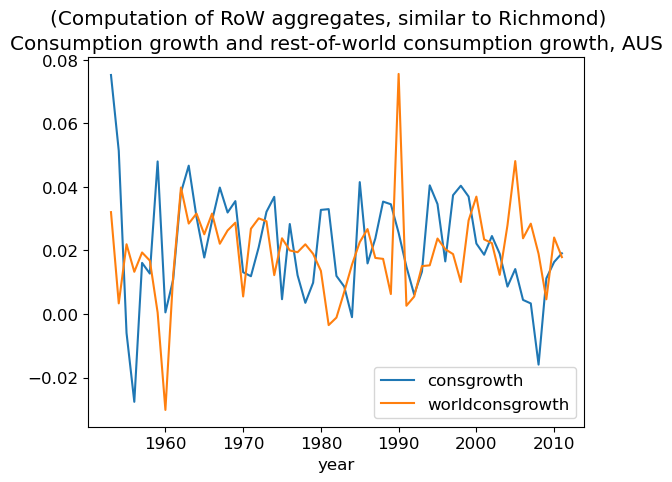

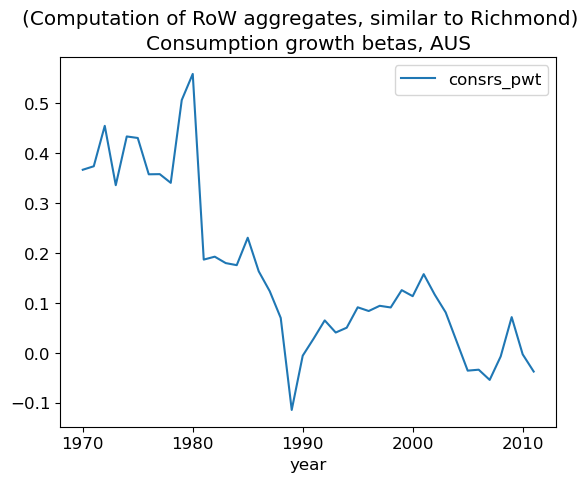

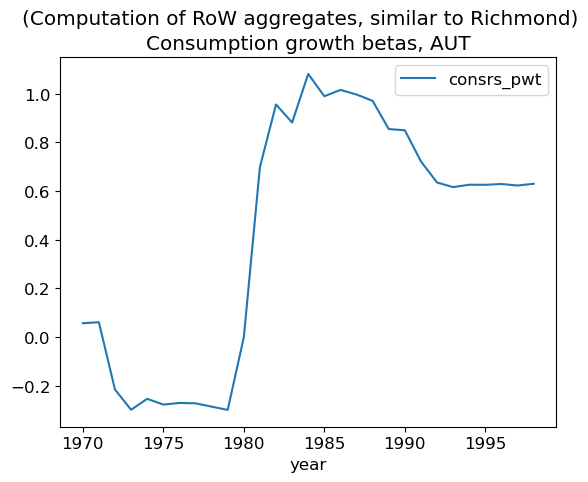

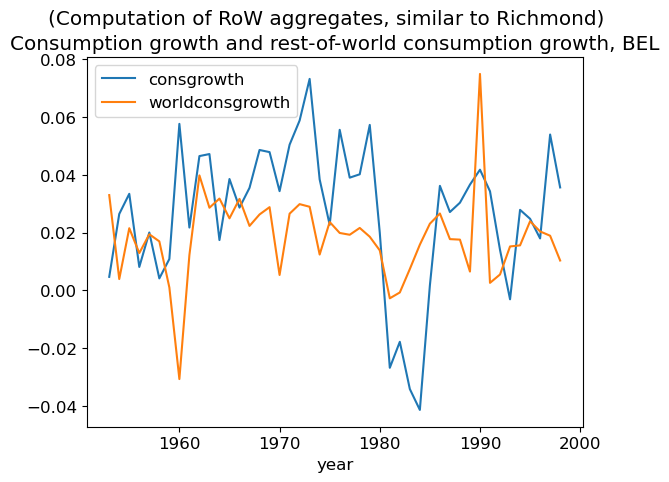

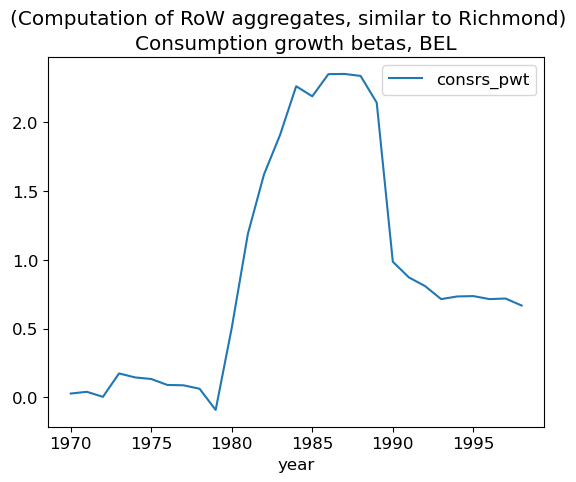

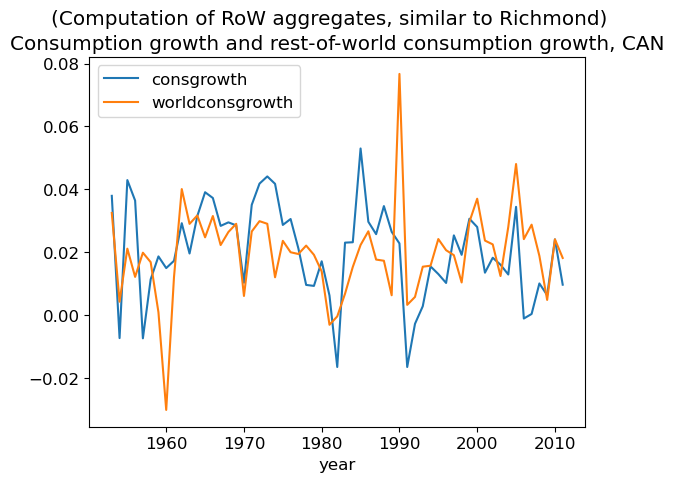

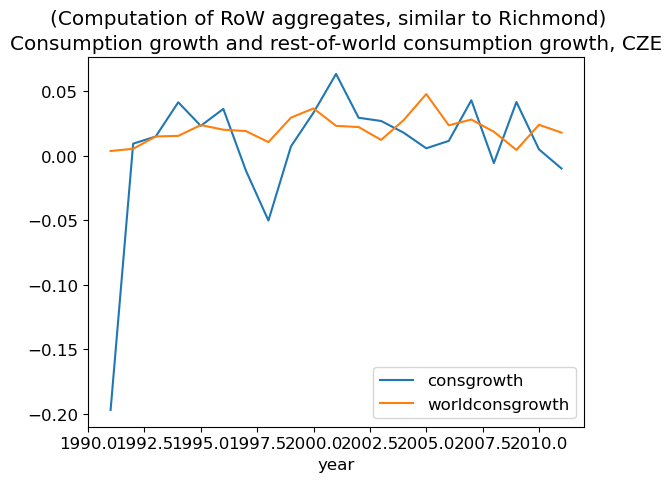

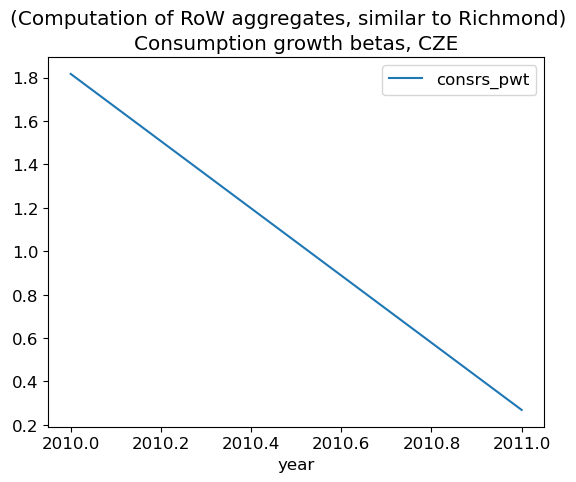

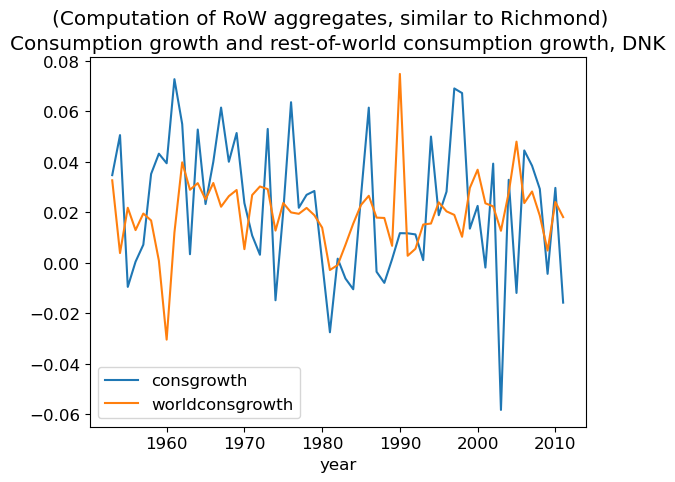

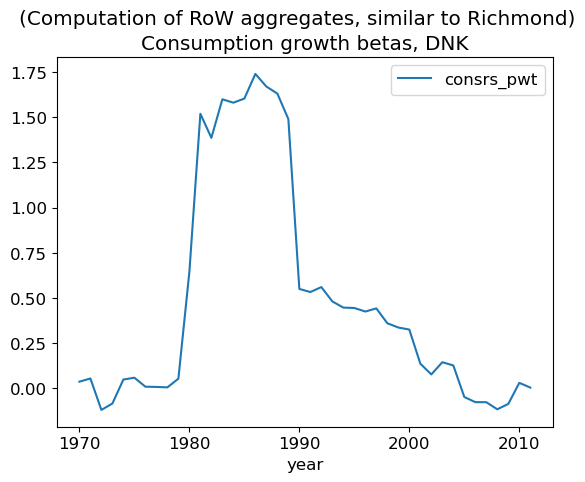

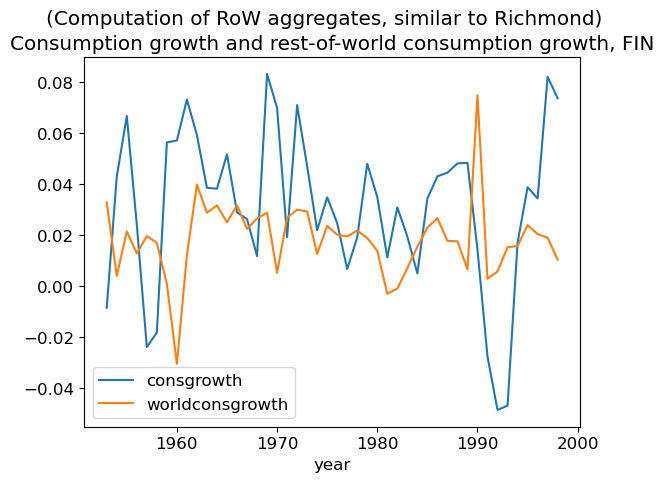

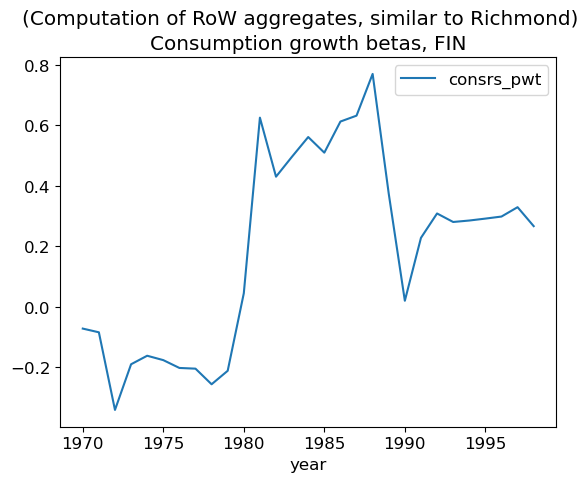

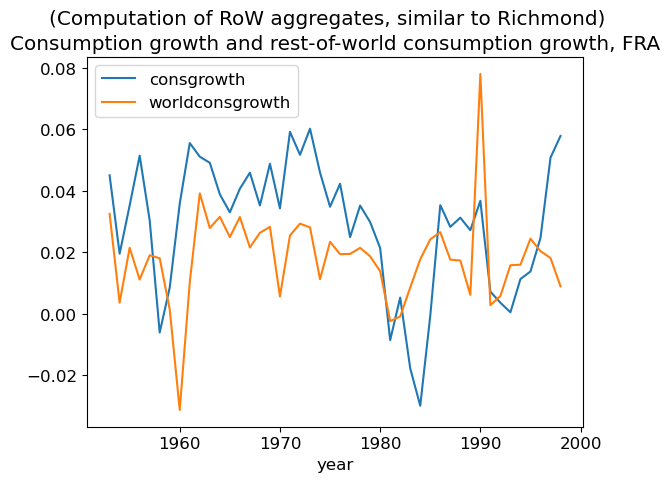

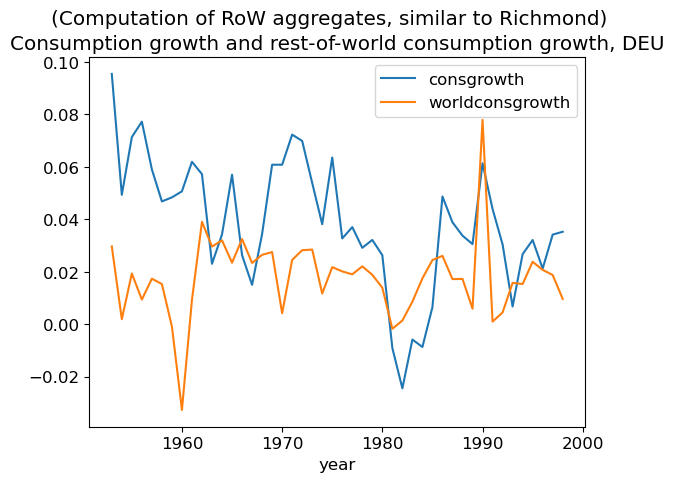

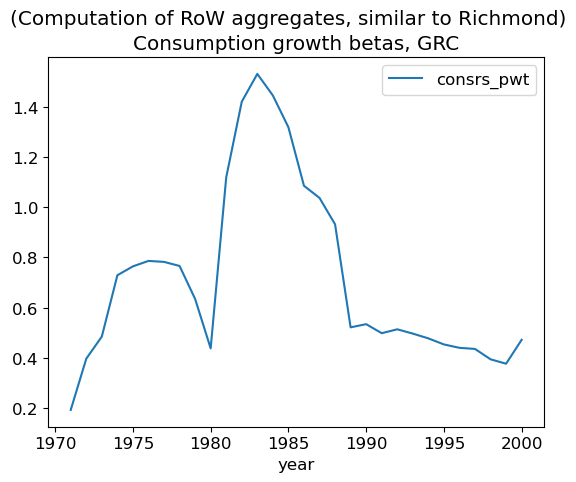

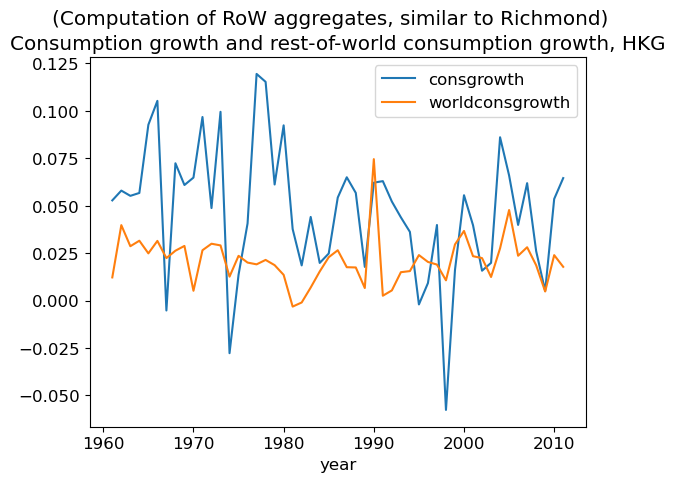

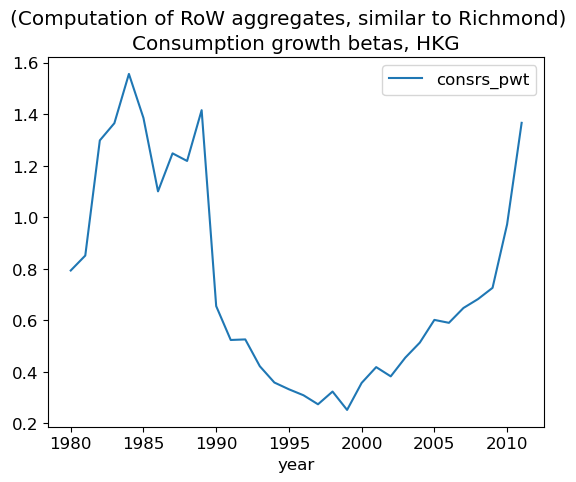

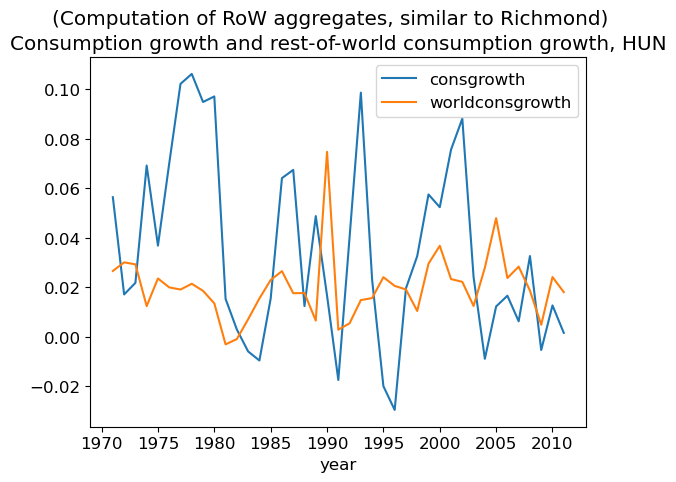

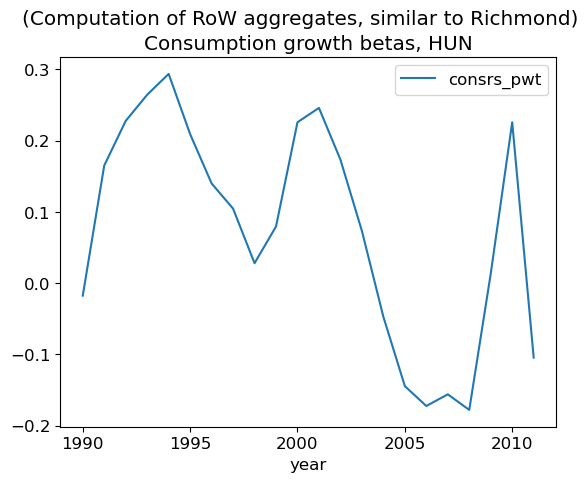

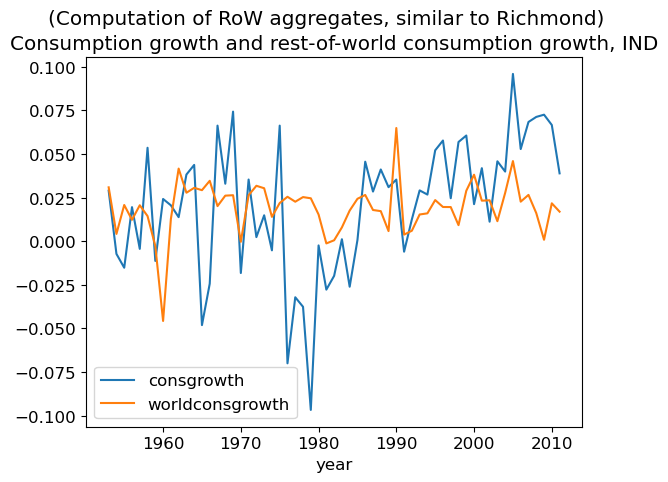

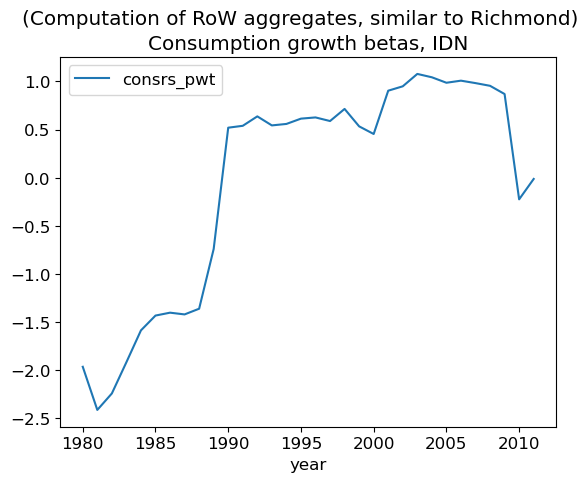

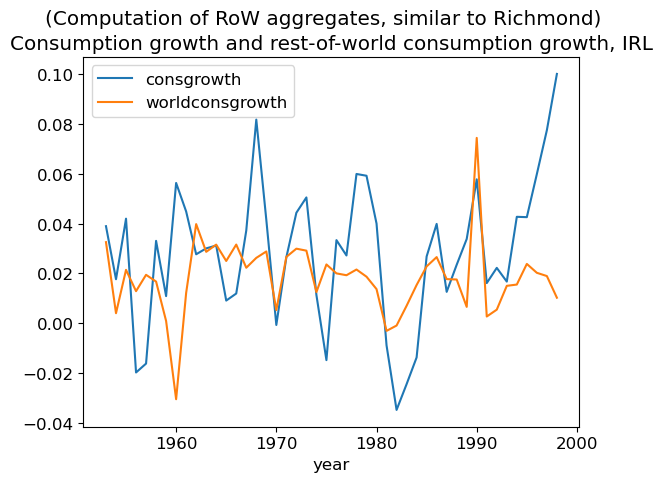

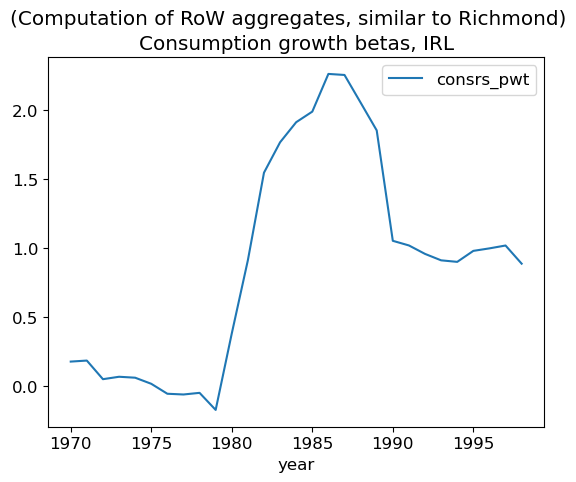

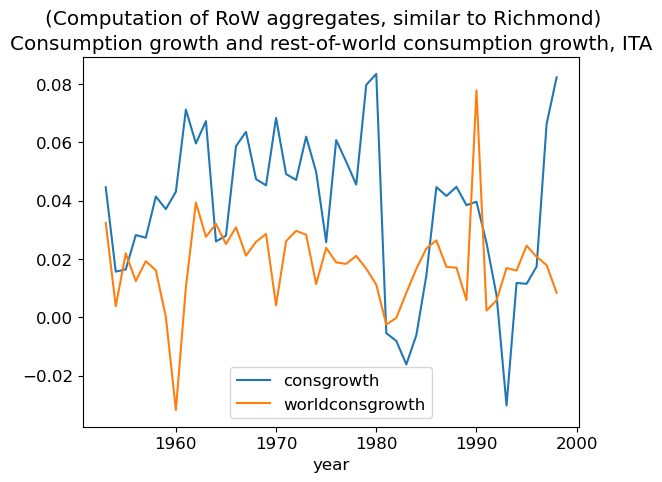

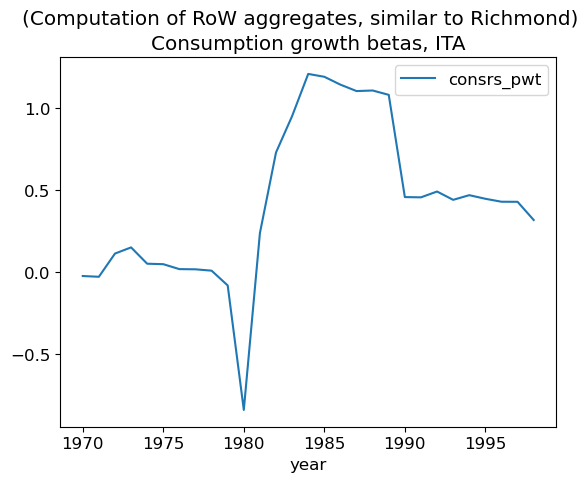

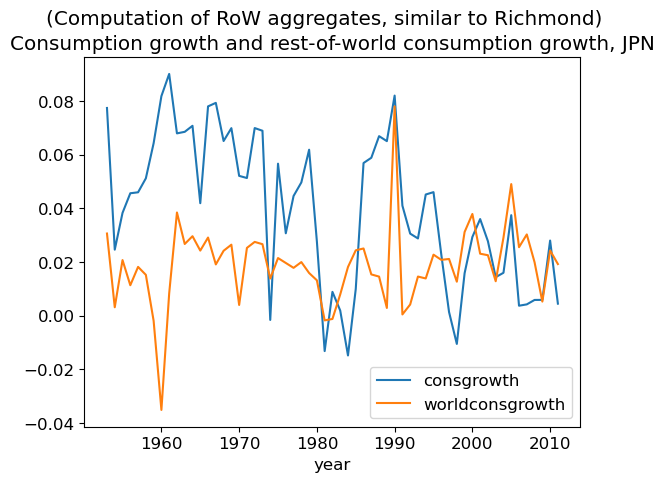

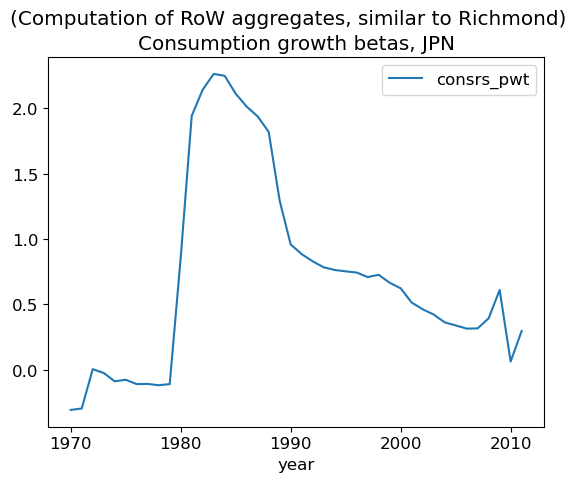

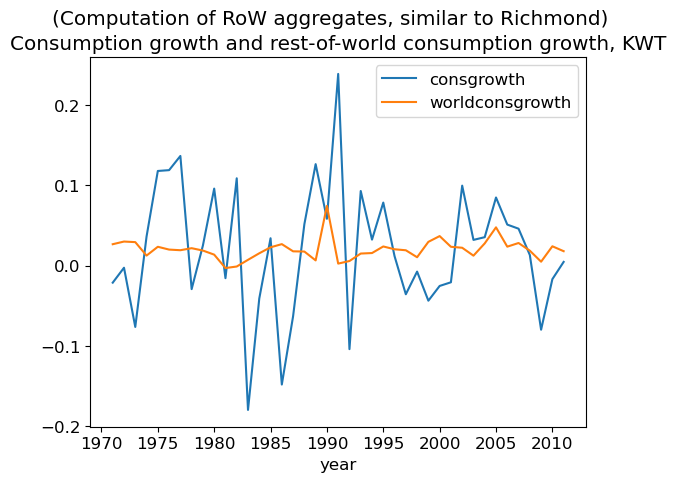

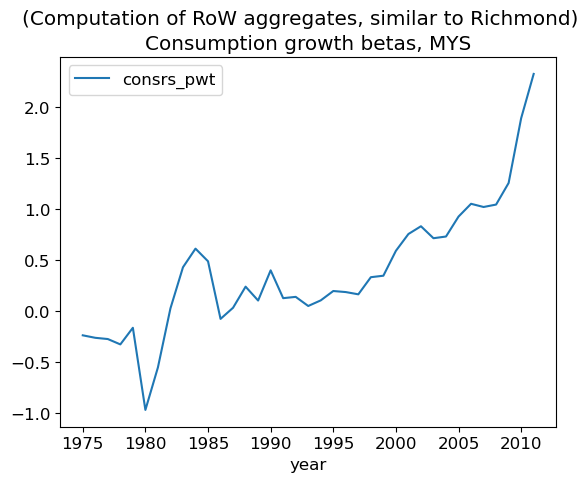

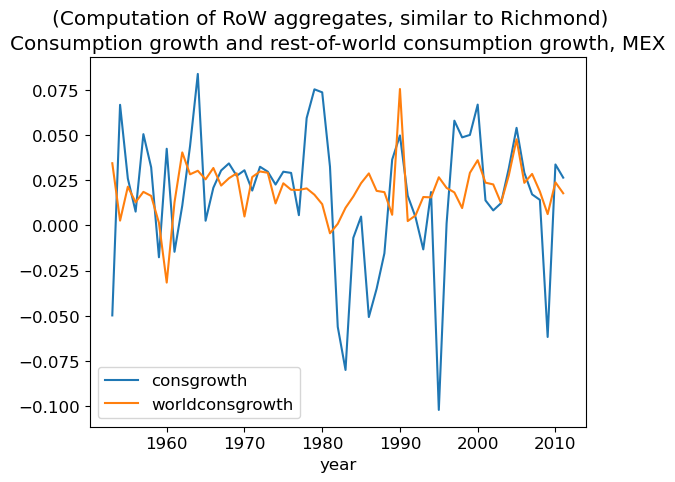

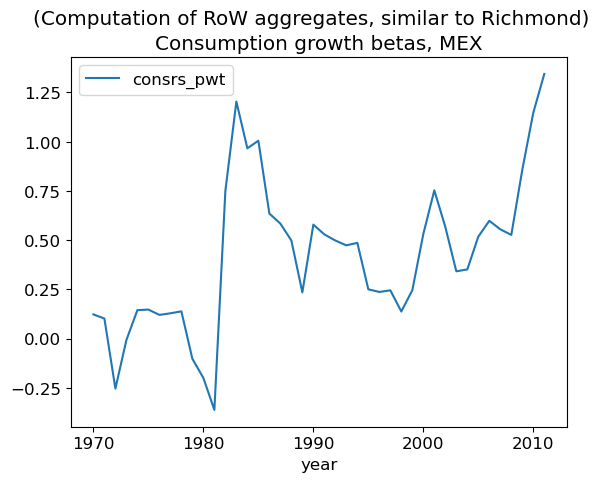

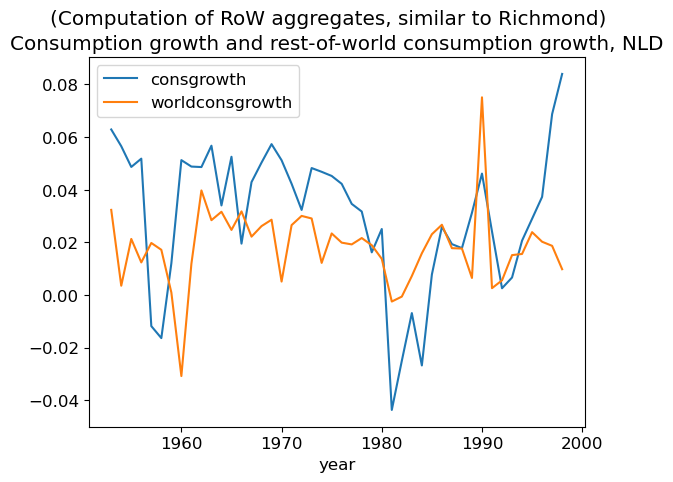

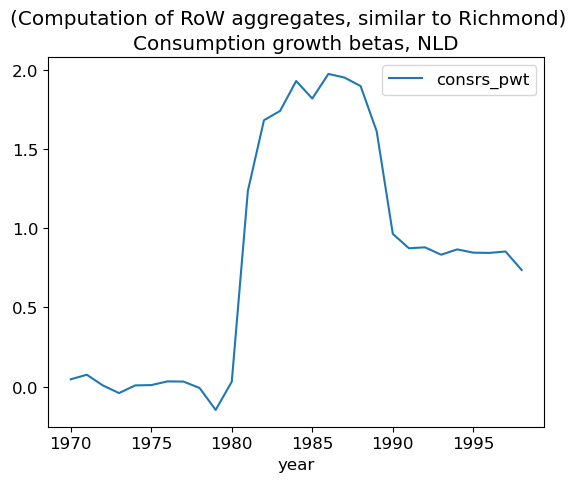

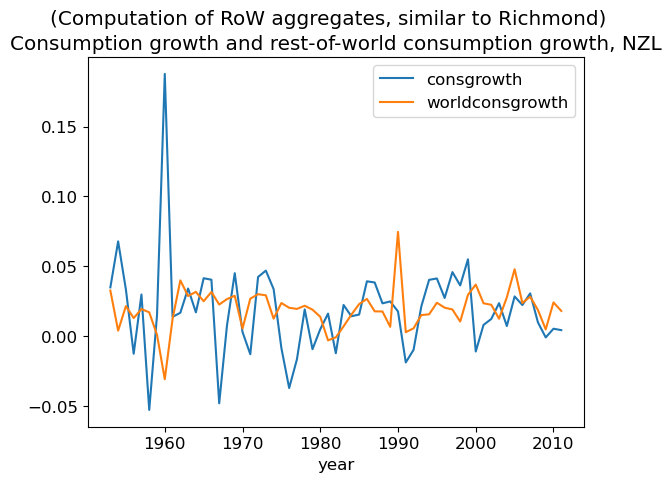

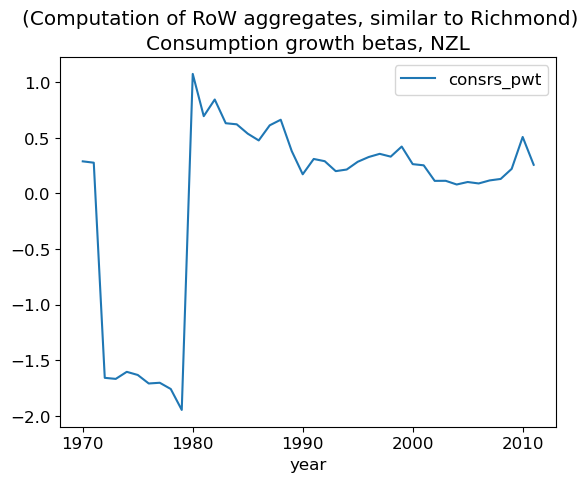

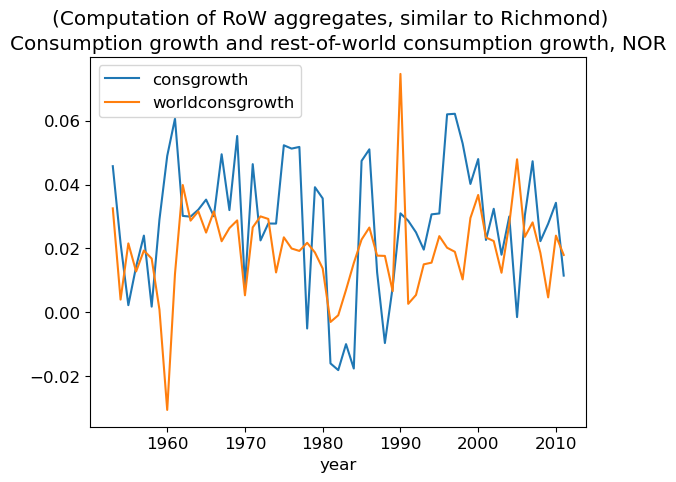

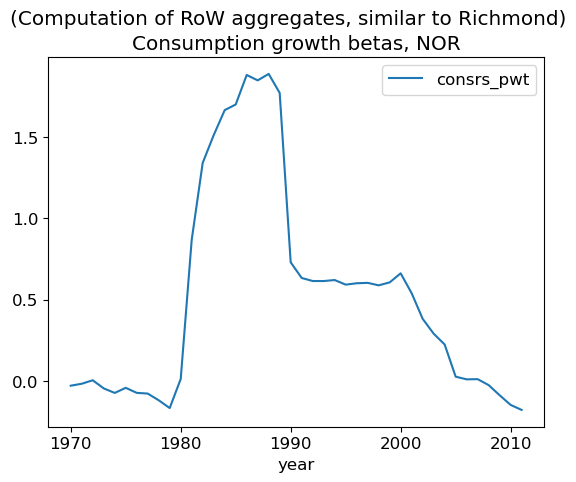

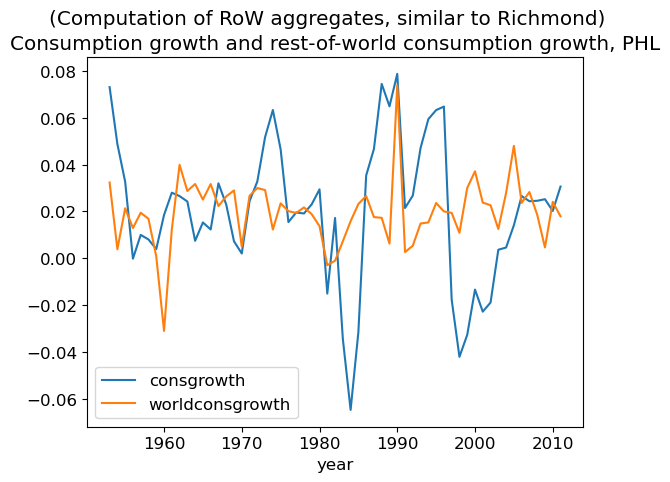

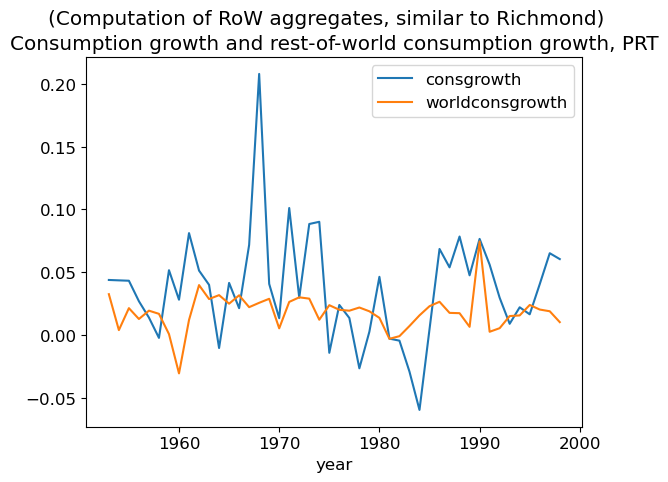

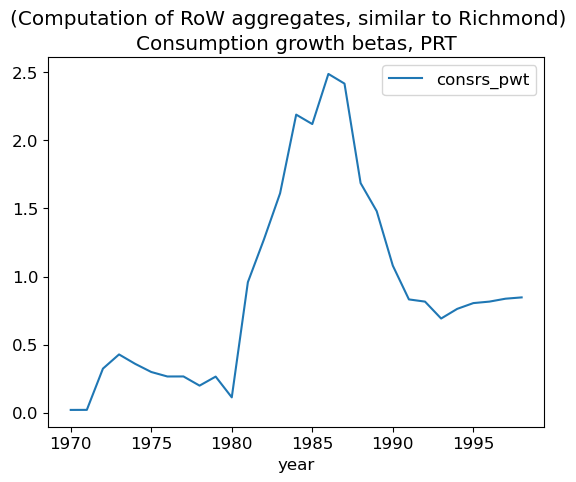

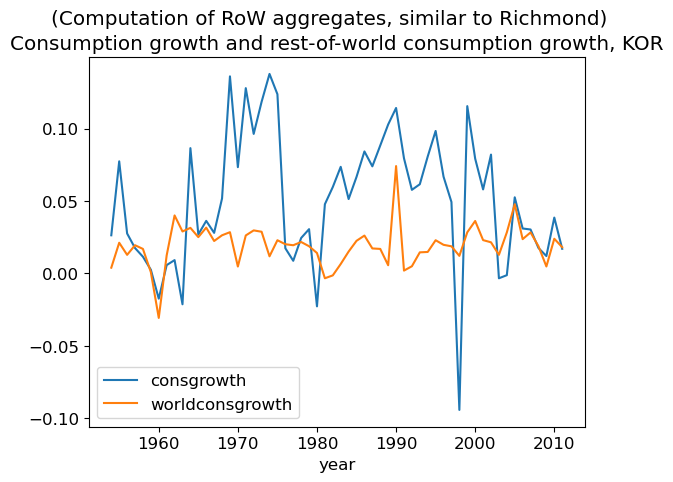

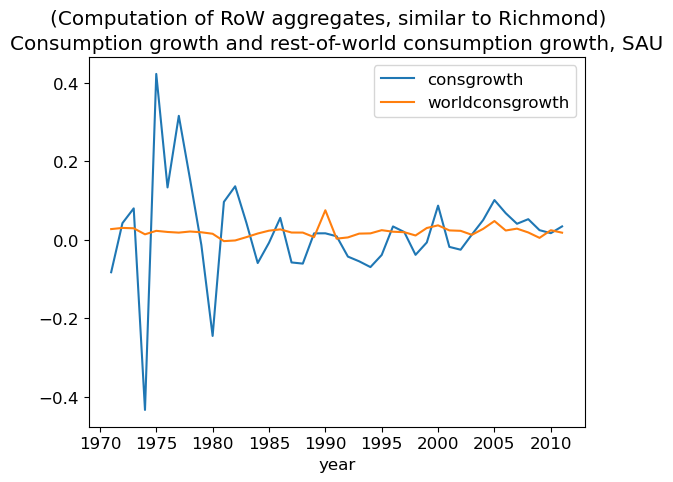

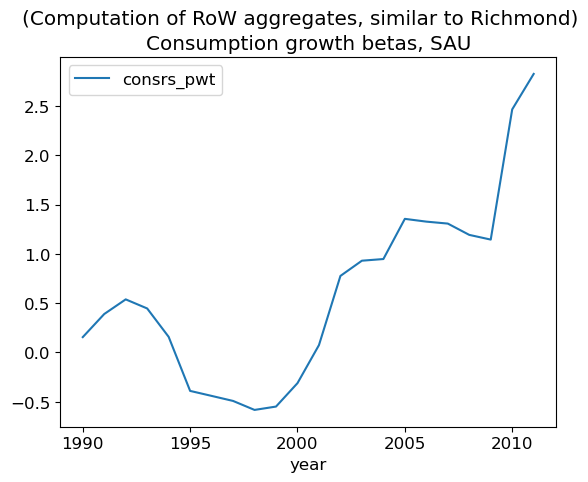

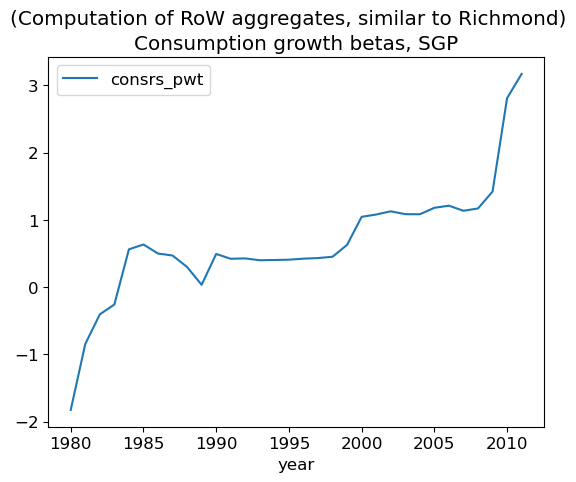

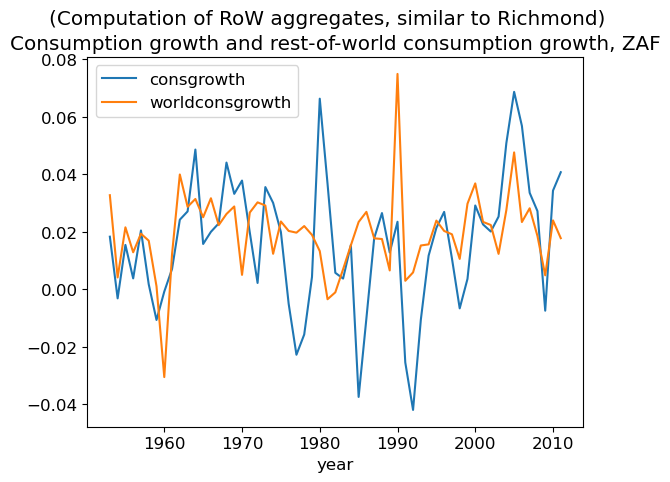

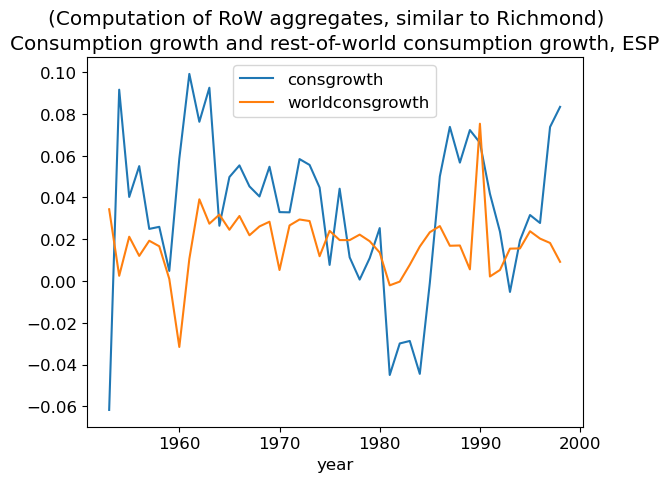

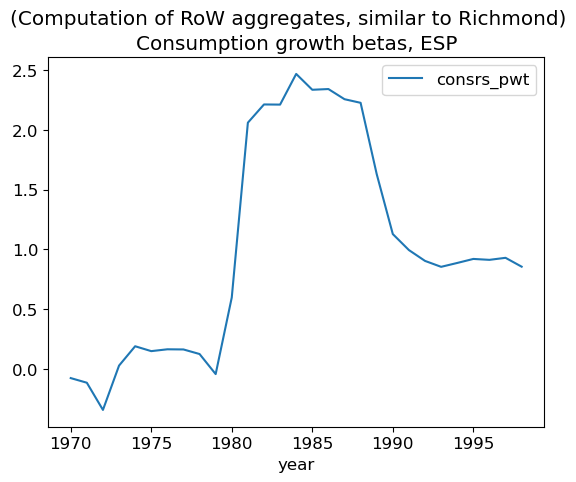

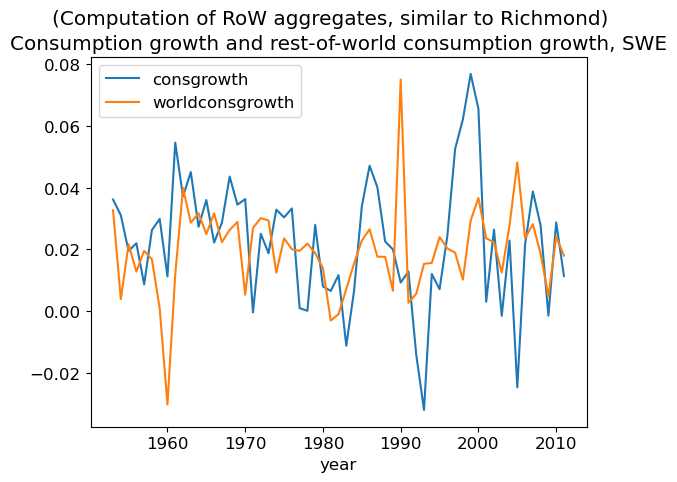

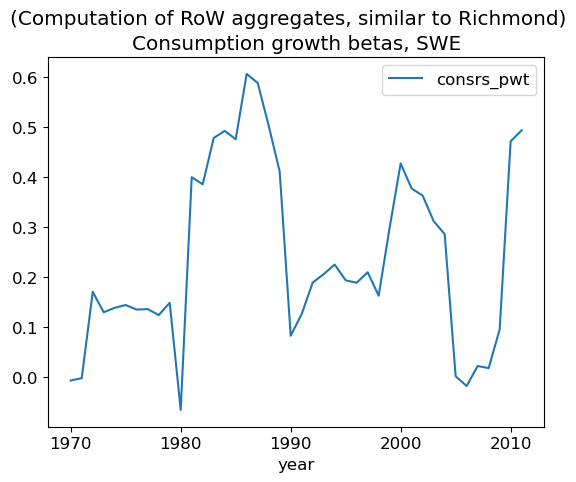

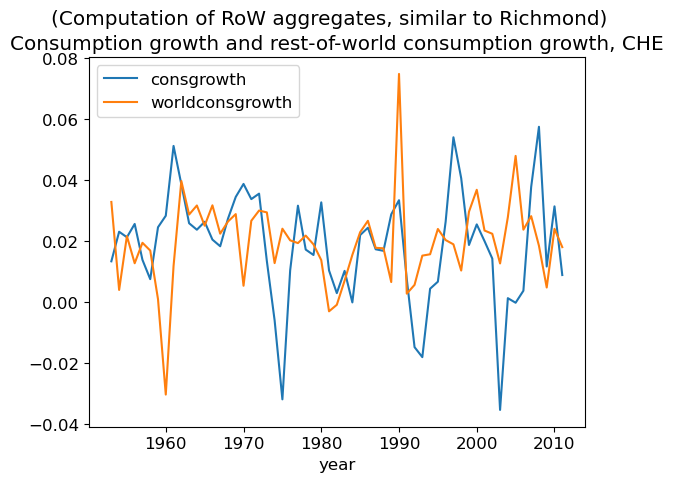

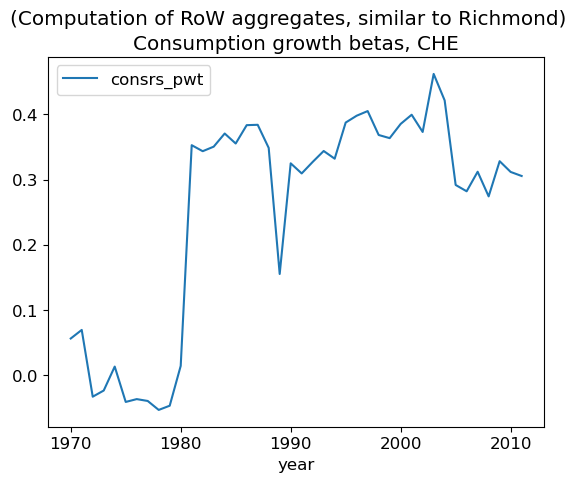

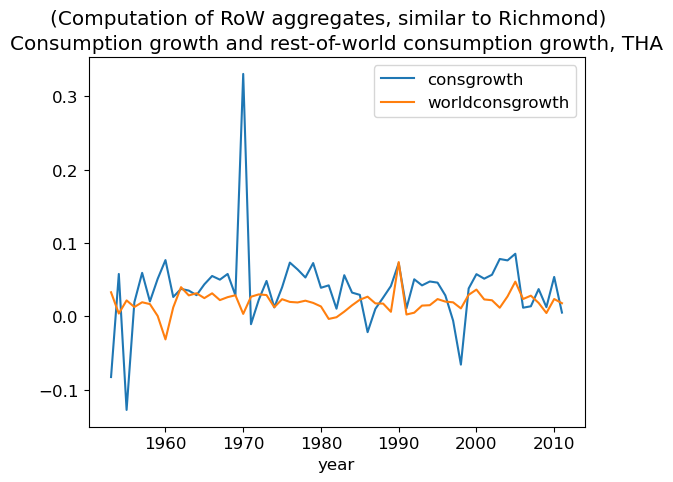

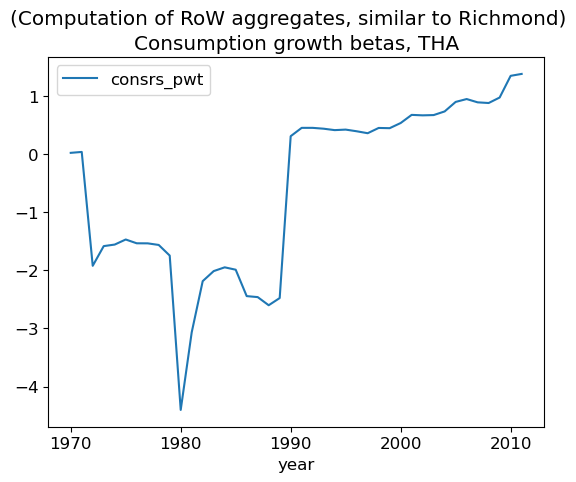

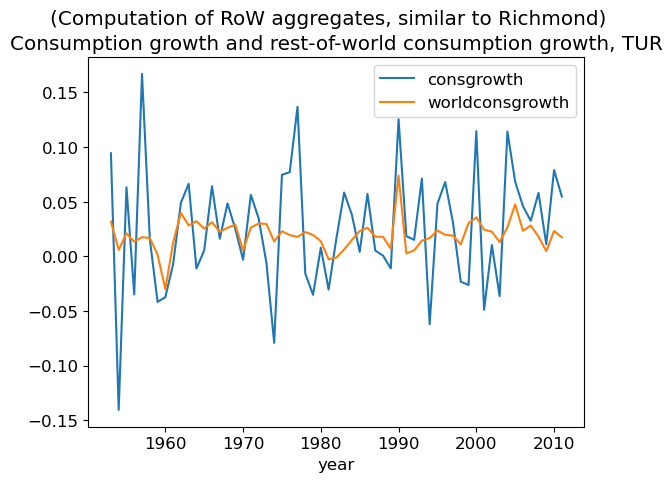

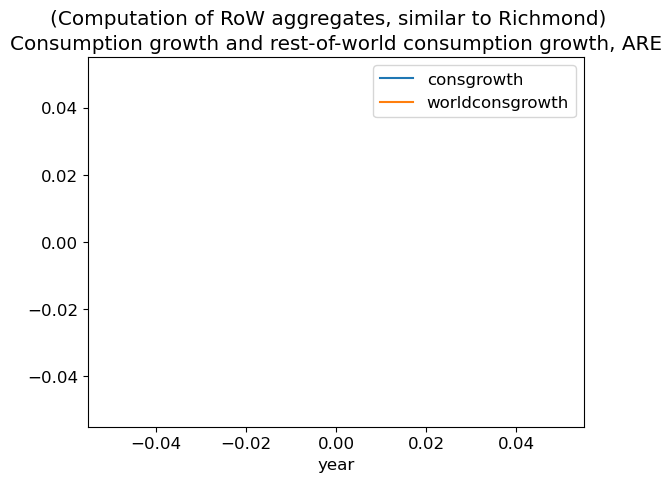

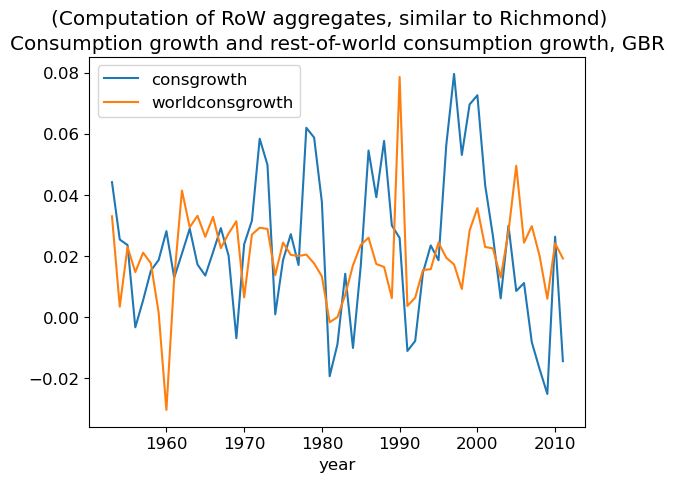

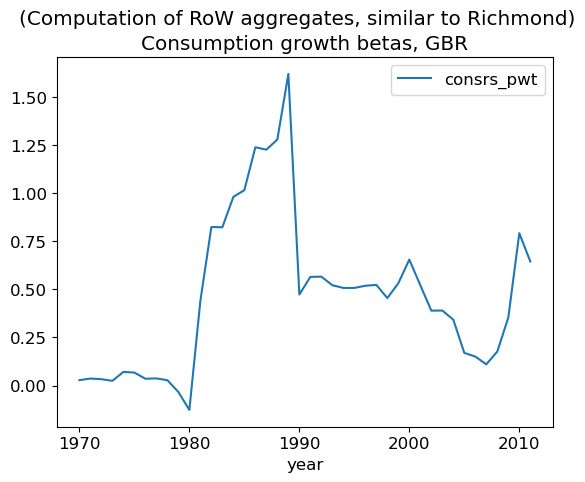

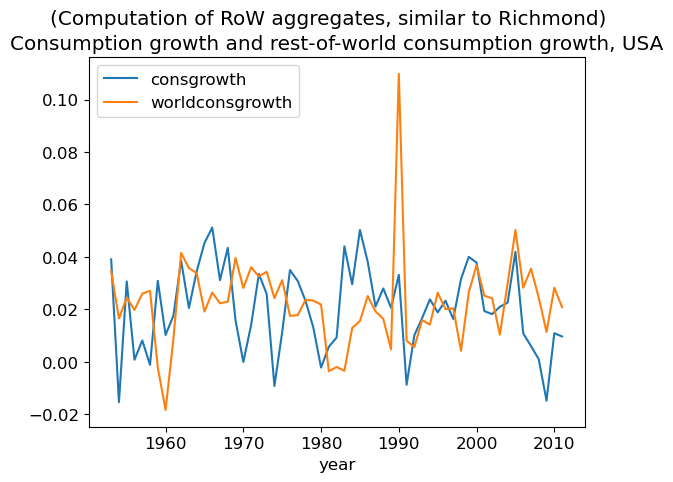

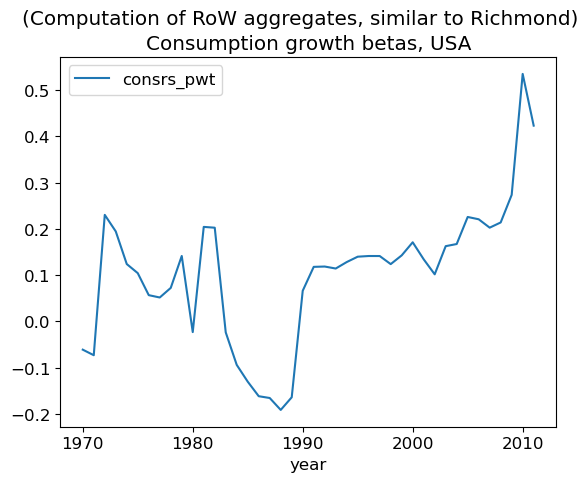

In [31]:
# double check rolling regression results

plt.rcParams.update({'font.size': 12})

for country in richmondcountries:
    # plots of own consumption growth and rest-of-world consumption growth together
    data = pwtsubdrop.loc[(pwtsubdrop['iso3'] == country) & (pwtsubdrop['year'] > 1952)]
    data.plot(x='year', y=['consgrowth', 'worldconsgrowth'], kind='line')
    plt.title('Consumption growth and rest-of-world consumption growth, ' + country)
    plt.suptitle("(Computation of RoW aggregates, similar to Richmond)")
    
    # plots of estimated betas
    betas = rscoef_pwt.loc[(rscoef_pwt['iso3'] == country)]
    betas.plot(x='year', y='consrs_pwt', kind='line')
    plt.title('Consumption growth betas, ' + country)
    plt.suptitle("(Computation of RoW aggregates, similar to Richmond)")


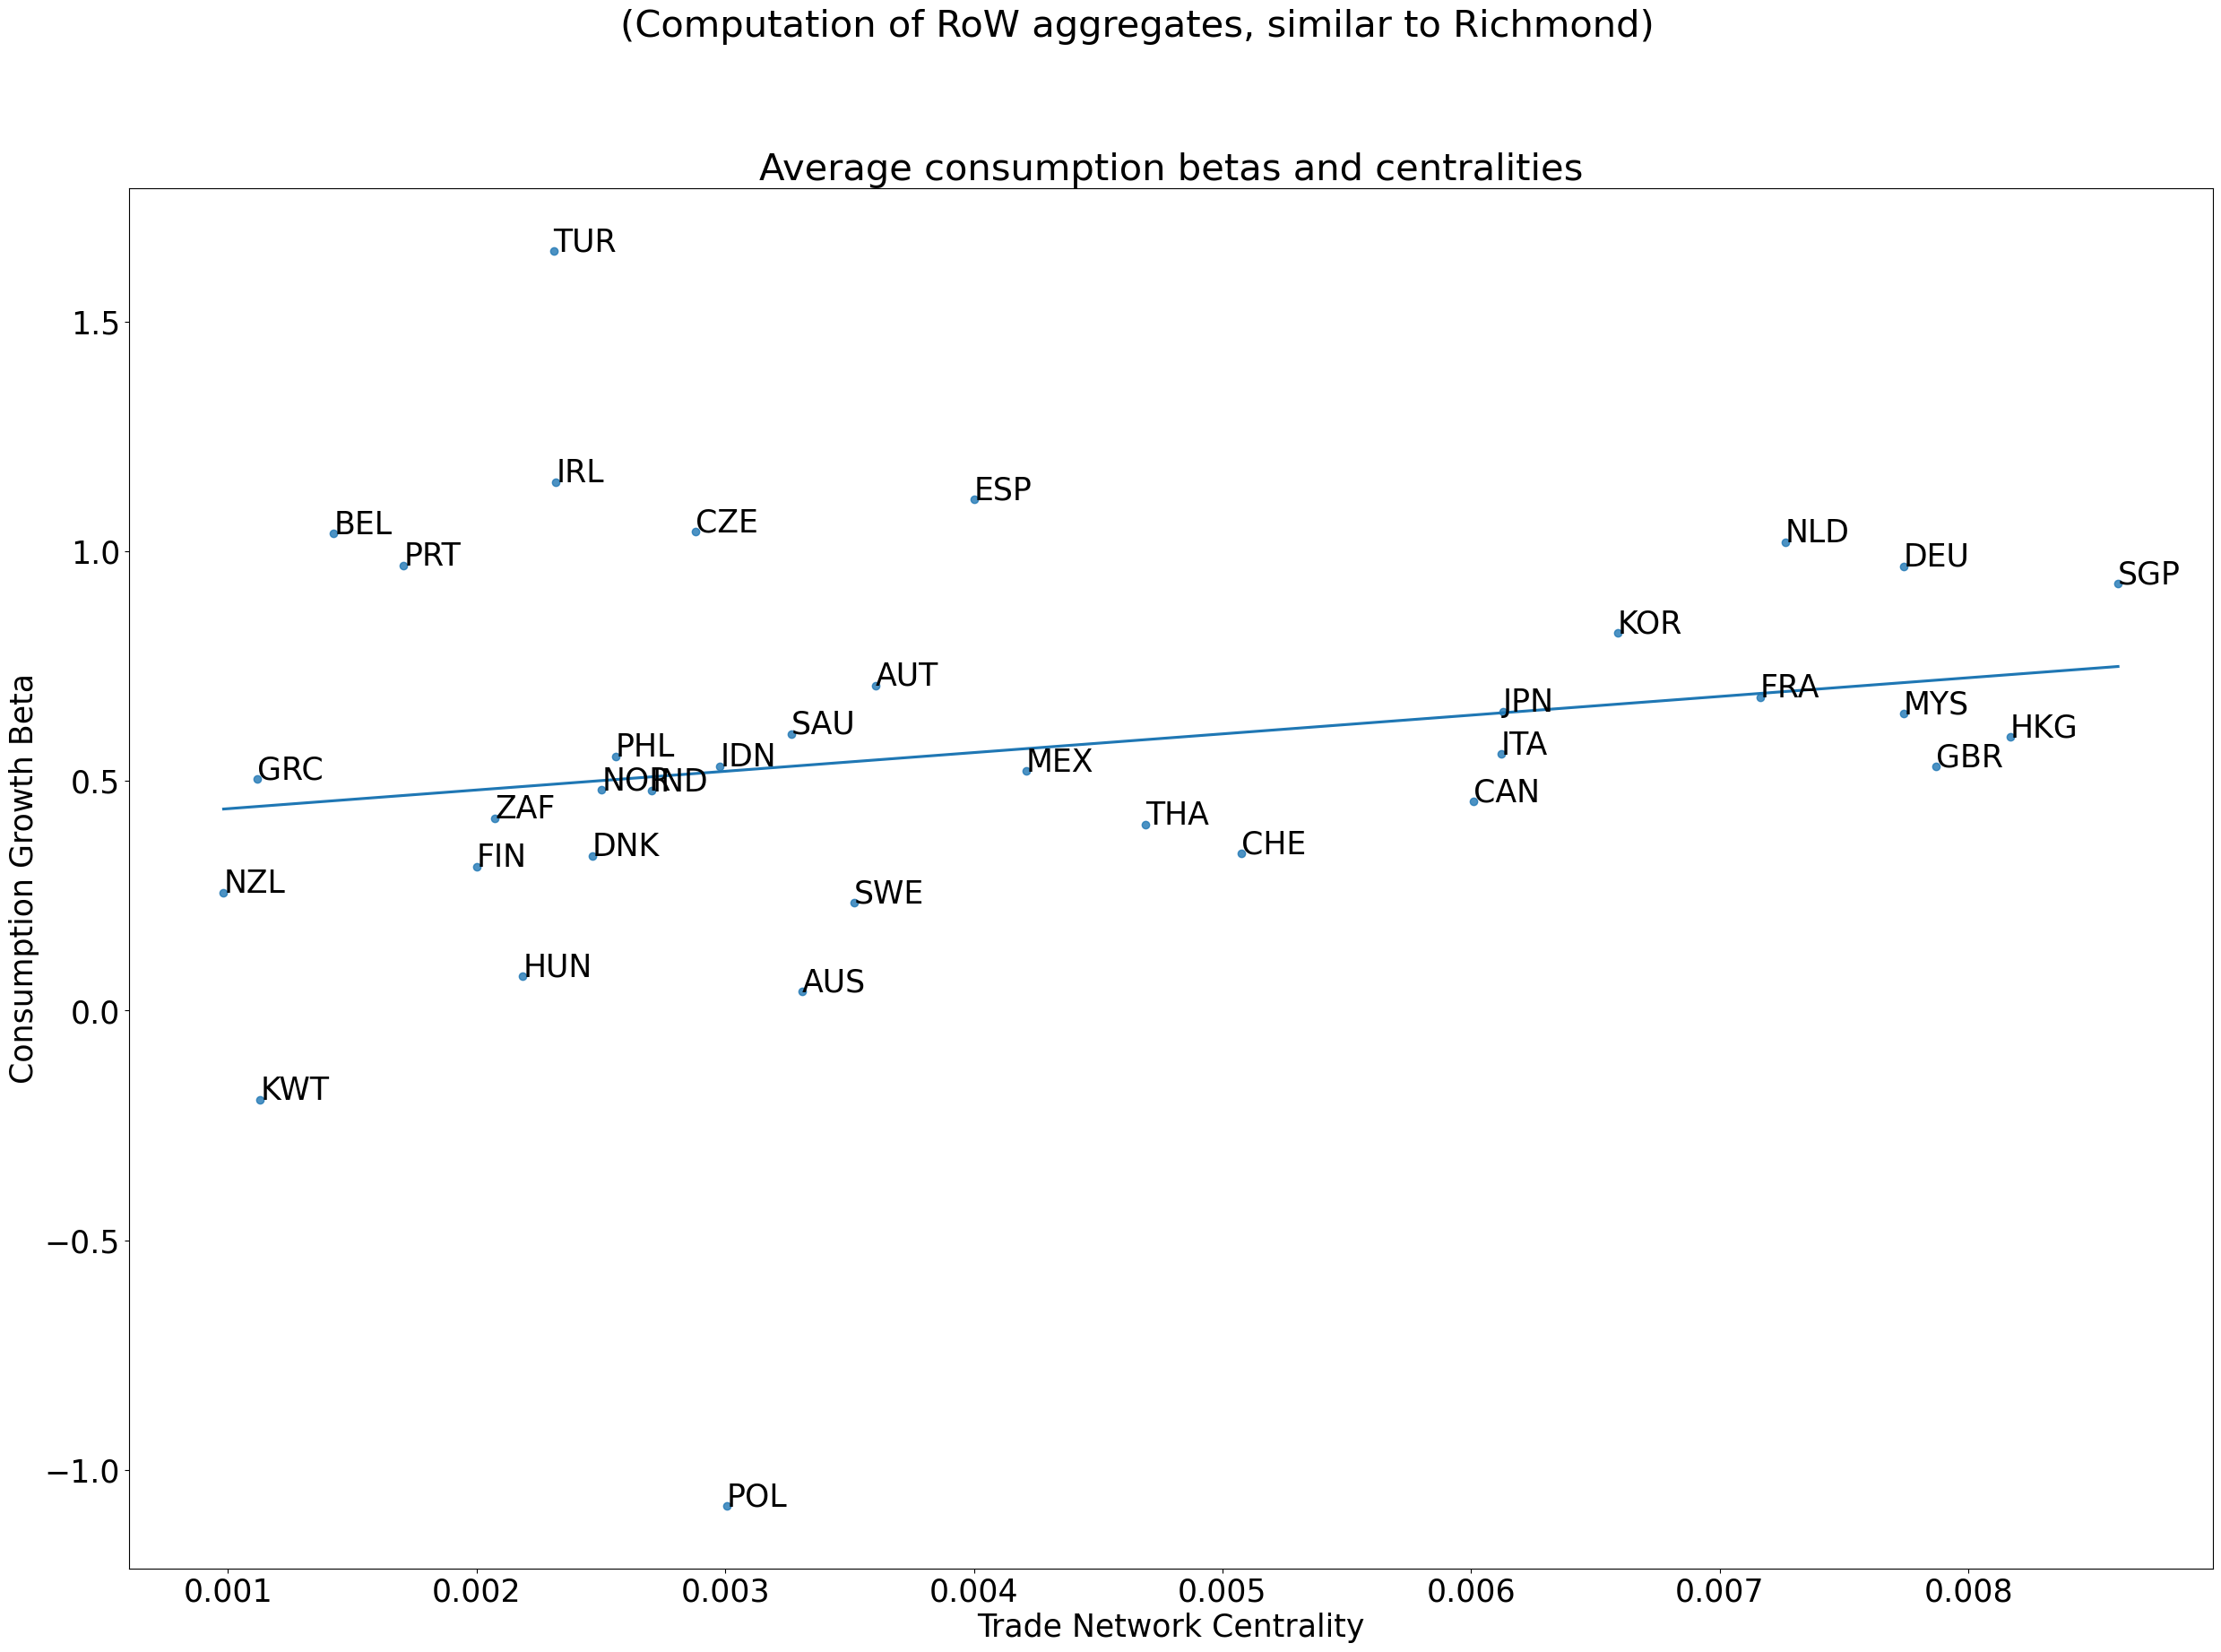

In [32]:
# recreate figure 4

plt.rcParams.update({'font.size': 25})

figure4data = out[['iso3', 'cent_exp', 'consrs_pwt']].loc[(out['year'] > 1987) & (out['iso3'].isin(richmondcountries_nous))]

averagecentrality = figure4data.groupby(['iso3'])['cent_exp'].mean().reset_index()
averagebetas = figure4data.groupby(['iso3'])['consrs_pwt'].mean().reset_index()

figure4data = pd.merge(left=averagecentrality, right=averagebetas, how='inner')

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=figure4data['cent_exp'],y=figure4data['consrs_pwt'],ci=None)
# set labels
ax.set_xlabel('Trade Network Centrality')
ax.set_ylabel('Consumption Growth Beta')

# plt.title('Average consumption betas and centralities (including all Euro data)')
plt.title('Average consumption betas and centralities')
plt.suptitle("(Computation of RoW aggregates, similar to Richmond)")

# annotate points in axis
for idx, row in figure4data.iterrows():
    ax.annotate(row['iso3'], (row['cent_exp'], row['consrs_pwt']) )


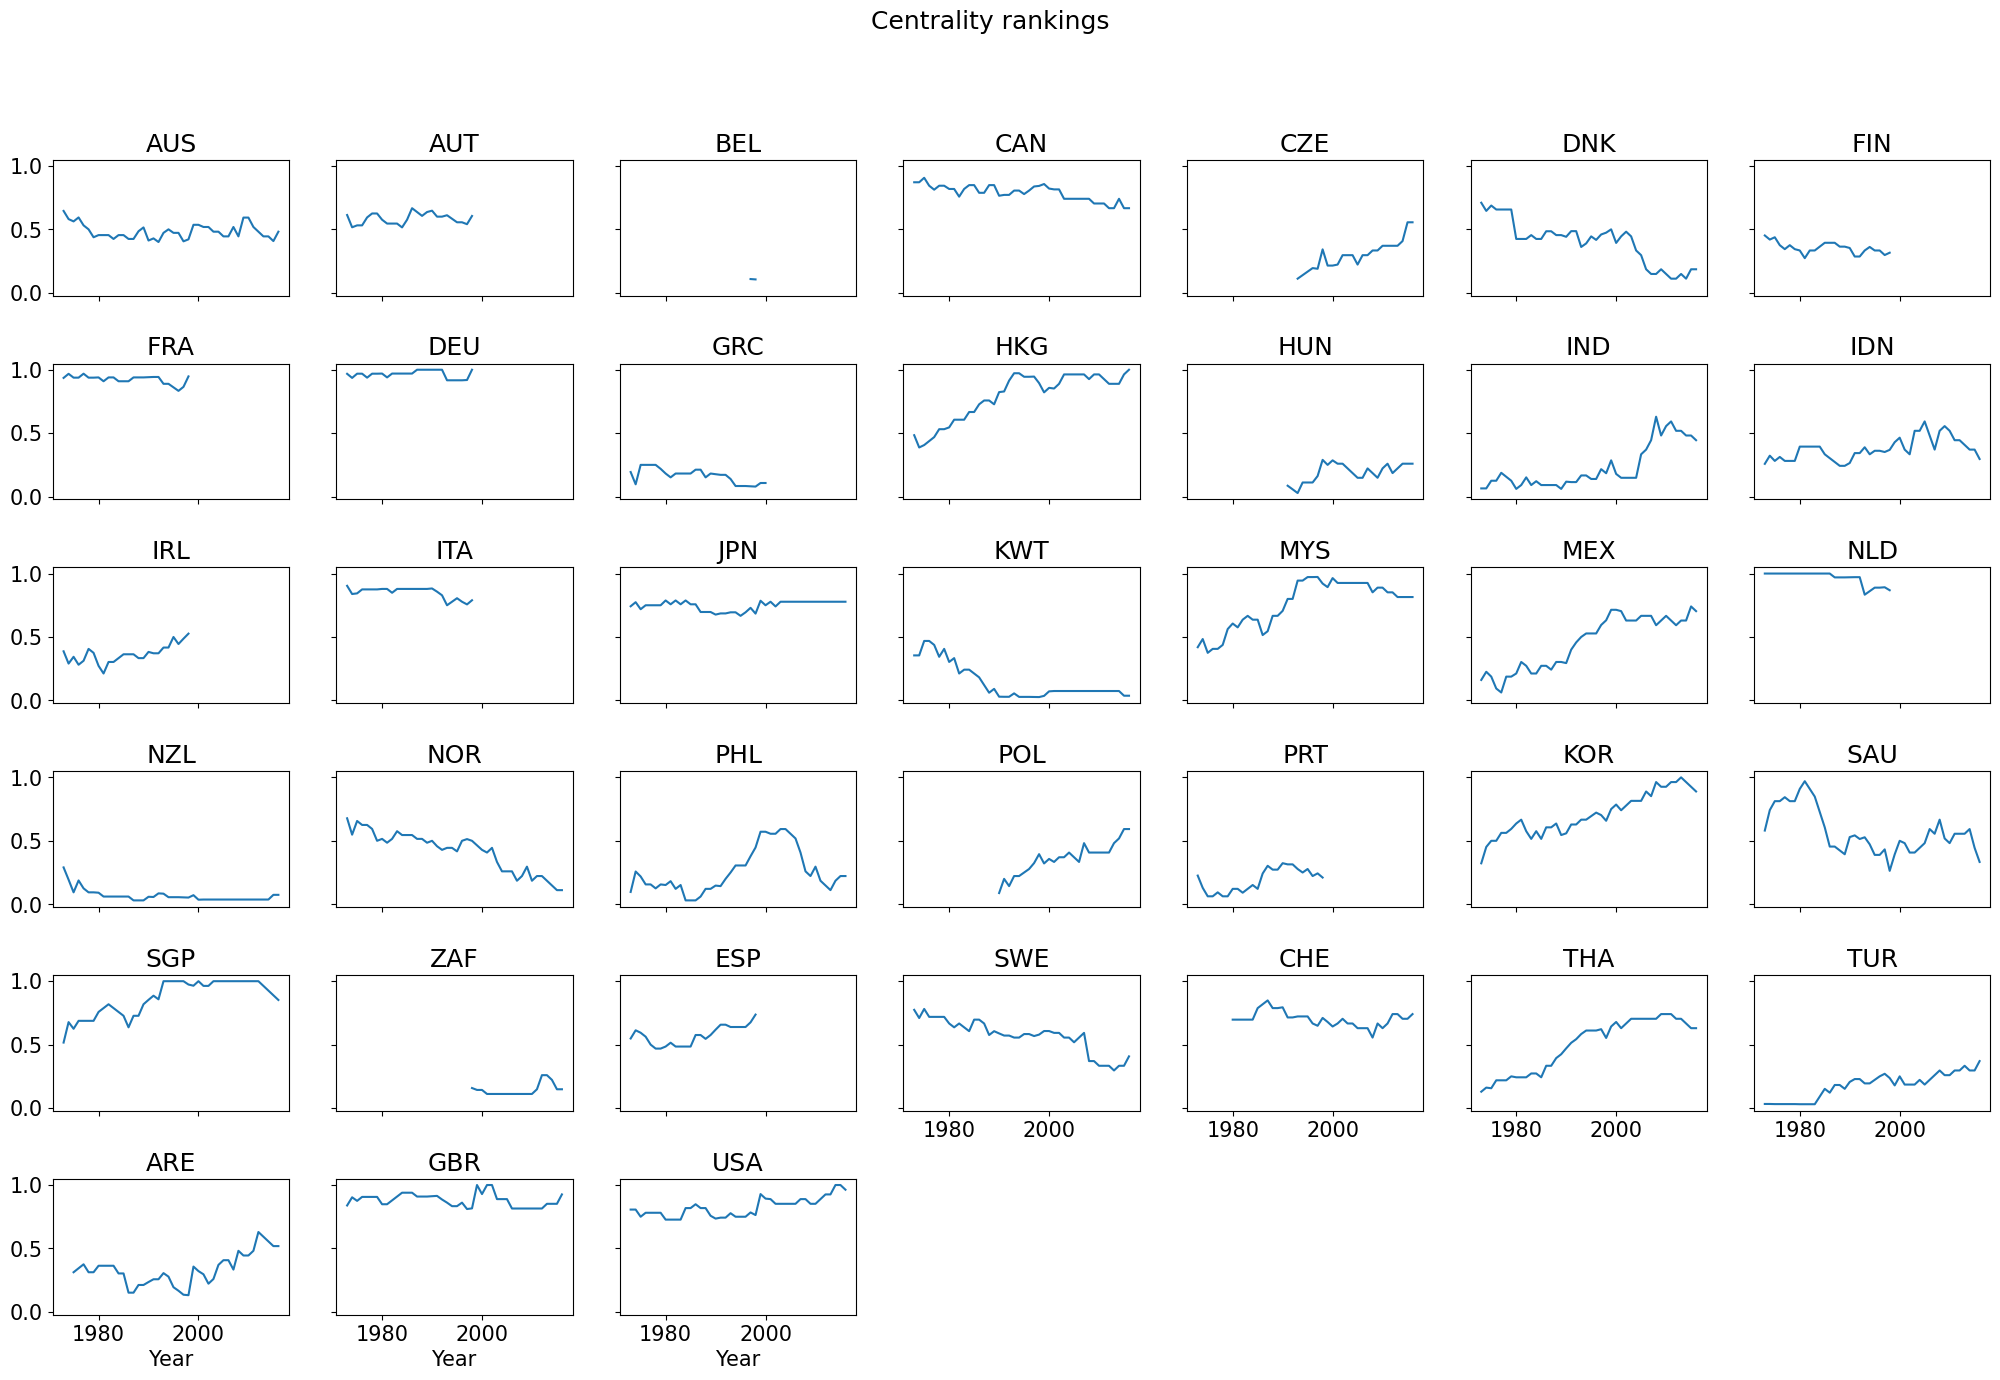

In [33]:
figure3data = cent[['iso3', 'year', 'cent_exp']].loc[(cent['iso3'].isin(richmondcountries)) & ((cent['year'] >= 1973) & (cent['year'] <= 2016))]

for method in ['average', 'min', 'max', 'dense', 'first']:
    figure3data[f'{method}_rank'] = figure3data.groupby(['year'])['cent_exp'].rank(method, pct=True)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(6, 7, sharex=True, sharey=True, figsize=(25, 15))
plt.subplots_adjust(hspace=0.5)
# plt.suptitle("Centrality rankings including all Euro data")
plt.suptitle("Centrality rankings")

# loop through the length of tickers and keep track of index
for n, country in enumerate(richmondcountries):
    # add a new subplot iteratively
    ax = plt.subplot(6, 7, n + 1)

    # filter df and plot ticker on the new subplot axis
    figure3data[figure3data["iso3"] == country].plot(y=['average_rank'], x='year', ax=ax, legend=None)

    # chart formatting
    ax.title.set_text(country)
    ax.set_xlabel("Year")
    
for column in range(3,7,1):
    axes[5,column].set_axis_off()
    axes[4,column].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False)
